In [14]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import itertools # Importando itertools para generar combinaciones de columnas
# Importando la función seasonal_decompose para la descomposición de series temporales
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.patches as mpatches
import payments_manager as pm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Importa la función para crear la matriz de confusión
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

cr_cp = pm.df('cr_cp')
fe_cp = pm.df('fe_cp')

df_jo = pm.df('df_jo')
df_jo = pm.sort("df_jo", ["id_cr"]).reset_index()
df_jo = df_jo.drop(columns=['index'])

df_jo_cp = df_jo.copy()

## probando k-means / clustering

In [18]:
df_transformado = df_jo_cp.copy()

# Convertir columnas datetime a timestamps
for col in df_transformado.select_dtypes(include=['datetime64']).columns:
    df_transformado[col] = df_transformado[col].apply(lambda x: x.timestamp() if pd.notnull(x) else None)
    
# Convertir columnas slot en enteros
df_transformado['created_at_slot'] = pd.to_numeric(df_transformado['created_at_slot'], errors='coerce').astype('Int64')
df_transformado['created_at_dow'] = pd.to_numeric(df_transformado['created_at_dow'], errors='coerce').astype('Int64')

# Reasignar valores en la columna 'transfer_type' y 'charge_moment' para convertirlo a numéricas
df_transformado = df_transformado.copy()
df_transformado['transfer_type'] = df_transformado['transfer_type'].map({'regular': 0, 'instant': 1})
df_transformado['charge_moment_numeric'] = df_transformado['charge_moment'].fillna('null').map({
    'before': 1,
    'after': 2,
    'null': 0  # Asigna 0 para los valores nulos llenados como 'null'
})
df_transformado['category'] = df_transformado['category'].fillna('null').map({'rejected': 1, 'month_delay_on_payment': 2, 'null':0})

# Descartar columna categorica
df_transformado=df_transformado.drop(columns=['charge_moment'])

# Convertir timedelta a float en días
df_transformado['to_receive_ini'] = df_transformado['to_receive_ini'] / pd.Timedelta(days=1)
df_transformado['to_receive_bank'] = df_transformado['to_receive_bank'] / pd.Timedelta(days=1)
df_transformado['to_reimbur'] = df_transformado['to_reimbur'] / pd.Timedelta(days=1)
df_transformado['to_reimbur_cash'] = df_transformado['to_reimbur_cash'] / pd.Timedelta(days=1)
df_transformado['to_end'] = df_transformado['to_end'] / pd.Timedelta(days=1)
df_transformado['to_send'] = df_transformado['to_send'] / pd.Timedelta(days=1)

# Variable categorica type a numérica
df_transformado['type'] = df_transformado['type'].fillna('null').map({
    'instant_payment': 1,
    'split_payment': 2,    
    'incident': 3 ,
    'postpone' : 4,
    'null' : 0
})

# Variable categorica recovery_Status a numérica
df_transformado['recovery_status'] = df_transformado['recovery_status'].fillna('null').map({
    'completed': 1,
    'pending': 2,    
    'pending_direct_debit': 3 ,
    'null' : 0
})

# Variable categorica stat_cr a numérica
df_transformado['stat_cr'] = df_transformado['stat_cr'].fillna('null').map({
    'approved': 1,
    'money_sent': 2,    
    'rejected': 3 ,
    'pending': 4,
    'transaction_declined': 5,
    'waiting_user_information': 6,
    'direct_debit_rejected': 7,
    'canceled': 8,
    'direct_debit_sent': 9,
    'waiting_reimbursement': 10,
    'active': 11,
    'money_back': 12,    
    'null' : 0
})

# Variable categorica stat_fe a numérica
df_transformado['stat_fe'] = df_transformado['stat_fe'].fillna('null').map({
    'confirmed': 1,
    'rejected': 2,    
    'cancelled': 3 ,
    'accepted': 4,
    'null' : 0
})

# Descartar columnas repetidas
df_transformado=df_transformado.drop(columns=['created_at_d','created_at_slot_h','Mes_created_at'])

# Descartar columnas sin interés
df_transformado=df_transformado.drop(columns=['reason'])

# Guardamos los 'user_id originales
user_id=df_transformado['user_id']

In [19]:
# Crear el escalador
scaler = StandardScaler()

# Estandarizar todas las columnas
normalizado = scaler.fit_transform(df_transformado)

# Convertir de nuevo a DataFrame, preservando nombres de columnas e índices
df_escalado = pd.DataFrame(normalizado, columns=df_transformado.columns, index=df_transformado.index)

df_escalado.fillna(0, inplace=True)


df_escalado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 47 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_cr                       32092 non-null  float64
 1   id_fe                       32092 non-null  float64
 2   fe_cr_id                    32092 non-null  float64
 3   user_id                     32092 non-null  float64
 4   active                      32092 non-null  float64
 5   created_at                  32092 non-null  float64
 6   created_at_fe               32092 non-null  float64
 7   amount                      32092 non-null  float64
 8   fee                         32092 non-null  float64
 9   stat_cr                     32092 non-null  float64
 10  stat_fe                     32092 non-null  float64
 11  transfer_type               32092 non-null  float64
 12  type                        32092 non-null  float64
 13  to_receive_ini              320

In [20]:
# Sacar columnas que no son originales del dataframe
df_escalado=df_escalado.drop(columns=['needs_m_check','user_id','n_incidents','n_recovery','n_backs','n_fees','needs_m_check_recov'])

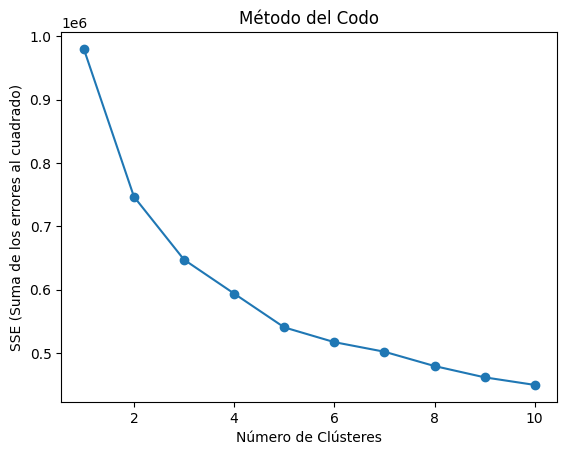

,id_cr,id_fe,fe_cr_id,active,created_at,created_at_fe,amount,fee,stat_cr,stat_fe,...,reco_last_update,updated_at_fe,cash_request_received_date,created_at_slot,created_at_dow,GBP_EUR,BTC_GBP,inflation,unemploy_rate,charge_moment_numeric
cluster,,,,,,,,,,,,,,,,,,,,,
0,-0.223780,-0.148989,-0.624059,0.133796,-0.098601,-0.605936,0.151859,0.722767,0.453644,-0.046859,...,-0.027204,-0.284165,-0.214216,-0.066363,-0.061739,0.038231,0.470161,-1.279874,0.165284,0.715876
1,1.080674,1.519270,0.828211,0.212575,0.952974,0.929017,-0.183470,0.722741,0.289411,-1.022648,...,0.258993,0.632986,0.838000,-0.000267,-0.251707,0.413394,0.744230,0.199746,0.792604,0.078875
2,-1.052166,-0.988067,0.000000,-0.499293,-0.883539,0.000000,0.376341,-1.381090,-1.851343,0.000000,...,0.000000,0.000000,-0.000370,0.072653,-0.088431,0.145246,-0.884253,0.674253,-1.123613,-1.289237
3,0.397363,0.447636,0.067581,0.173062,0.502205,0.175057,-0.011576,0.723457,0.478587,0.105598,...,0.126012,-0.341169,0.399214,-0.046116,0.036550,-0.091783,-0.175291,-0.375011,0.788383,0.707353
4,-1.197176,-0.988067,0.000000,0.064528,-1.047240,0.000000,0.414366,-1.381090,0.578156,0.000000,...,-0.089959,0.000000,-1.188145,0.073593,-0.017026,0.090485,-0.987604,0.437000,-1.322160,-1.289237
5,-1.103159,-0.547107,-1.604259,-0.099025,-0.866768,-1.485056,0.341375,0.723866,0.368197,-0.392796,...,-0.338597,-0.088150,-1.004861,0.079194,-0.023888,0.031961,-0.852719,0.519282,-1.131405,0.587115
6,0.242153,-0.988067,0.000000,-0.302799,0.315942,0.000000,-0.303620,-1.381090,-1.336097,0.000000,...,0.006105,0.000000,0.090184,0.007463,-0.049607,-0.012584,0.255290,-0.744252,0.546244,-1.289237
7,1.299987,1.334007,1.027926,0.212145,1.045166,0.846343,-0.510744,0.660149,0.493804,0.172907,...,0.135557,0.446562,0.961971,-0.114886,1.455131,-1.982464,1.206976,0.226350,0.792604,0.660859
8,-1.790235,-0.988067,0.000000,-0.358530,-3.332252,0.000000,0.431515,-1.381090,-0.343598,0.000000,...,-0.195912,0.000000,-2.215008,0.047198,-0.054500,0.113734,-2.243548,3.104283,-2.372090,-1.289237


In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Usar los datos ya escalados para clustering
data_scaled = df_escalado  # Asumiendo que ya está escalado

# Encontrar el número óptimo de clústeres (método del codo)
sse = []
for k in range(1, 11):  # Probar de 1 a 10 clústeres
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(data_scaled)
    sse.append(kmeans.inertia_)

# Graficar el método del codo
plt.plot(range(1, 11), sse, marker='o')
plt.xlabel('Número de Clústeres')
plt.ylabel('SSE (Suma de los errores al cuadrado)')
plt.title('Método del Codo')
plt.show()

# Elegir un número de clústeres basado en el gráfico 
clusters = kmeans.fit_predict(data_scaled)

# Agregar los clústeres al DataFrame escalado
df_escalado['cluster'] = clusters

# Ver resultados
results=df_escalado.groupby('cluster').mean()  # Promedio de características por grupo
results

In [22]:
from sklearn.cluster import KMeans

# Entrenar KMeans con 4 clústeres
kmeans = KMeans(n_clusters=5, random_state=42)
kmeans.fit(data_scaled)  # Usamos los datos escalados (suponiendo que ya los tienes)

# Predecir el clúster para cada registro
clusters = kmeans.predict(data_scaled)

# Agregar la columna 'cluster' al DataFrame original
df_transformado['cluster'] = clusters

# Ver el número de registros en cada clúster
df_transformado['cluster'].value_counts()


cluster
0    10857
3     7195
2     6623
1     6482
4      935
Name: count, dtype: int64

In [24]:
# Volvemos a poner 'user_id' después de hacer el clustering:
df_transformado['user_id'] = user_id
df_transformado.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 48 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id_cr                       32092 non-null  int64  
 1   id_fe                       32092 non-null  int64  
 2   fe_cr_id                    21055 non-null  float64
 3   user_id                     32092 non-null  int64  
 4   active                      32092 non-null  int64  
 5   created_at                  32092 non-null  float64
 6   created_at_fe               21055 non-null  float64
 7   amount                      32092 non-null  float64
 8   fee                         32092 non-null  float64
 9   stat_cr                     32092 non-null  int64  
 10  stat_fe                     21055 non-null  float64
 11  transfer_type               32092 non-null  int64  
 12  type                        21055 non-null  float64
 13  to_receive_ini              253

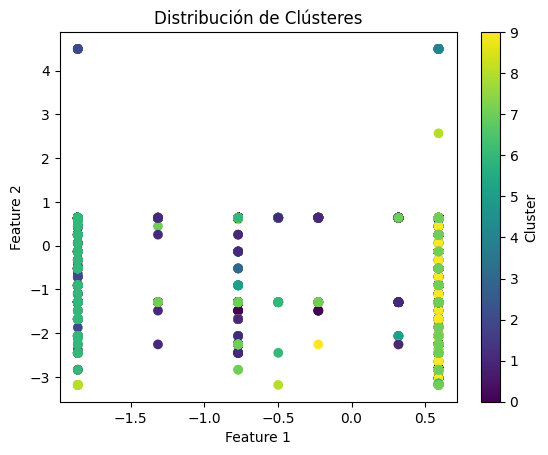

In [25]:
import matplotlib.pyplot as plt

# Seleccionar dos características para la visualización 
plt.scatter(df_escalado['stat_cr'], df_escalado['amount'], c=df_escalado['cluster'], cmap='viridis')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Distribución de Clústeres')
plt.colorbar(label='Cluster')
plt.show()


Investigar en cada cluster qué tipo de clientes hay a ver si tiene algun sentido y se pueden dar insight accionables para cada cluster que beneficien a la empresa.

In [26]:
# DataFrame con datos originales por clusteres
cluster_0 = df_transformado[df_transformado['cluster'] == 0]
cluster_1 = df_transformado[df_transformado['cluster'] == 1]
cluster_2 = df_transformado[df_transformado['cluster'] == 2]
cluster_3 = df_transformado[df_transformado['cluster'] == 3]
cluster_4 = df_transformado[df_transformado['cluster'] == 4]

In [28]:
# DataFrame con datos escalados por clusteres
cluster_0_scaled = df_escalado[df_transformado['cluster'] == 0]
cluster_1_scaled = df_escalado[df_transformado['cluster'] == 1]
cluster_2_scaled = df_escalado[df_transformado['cluster'] == 2]
cluster_3_scaled = df_escalado[df_transformado['cluster'] == 3]
cluster_4_Scaled = df_escalado[df_transformado['cluster'] == 4]

# Comparar características originales con las escaladas
#print("Promedios originales:\n", cluster_0.mean())
#print("Promedios escalados:\n", cluster_0_scaled.mean(axis=0))


In [48]:
cluster_0['amount'].value_counts()

amount
100.0    7459
50.0     2733
25.0      213
80.0       77
30.0       63
60.0       61
40.0       56
20.0       55
70.0       52
90.0       33
10.0       16
45.0       11
55.0        4
65.0        4
35.0        4
5.0         4
11.0        3
95.0        3
15.0        3
36.0        1
99.0        1
49.0        1
Name: count, dtype: int64